In [1]:
import os
import errno

import numpy as np

# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
        
import deepcell

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename, test_size=test_size, seed=seed)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (6480, 216, 256, 1)
y.shape: (6480, 216, 256, 1)


In [3]:
# the path to the data file is currently required for `train_model_()` functions

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [5]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='std',
    num_semantic_heads=3,
    num_semantic_classes=[1, 1, 2], # inner distance, outer distance, fgbg
    location=True,  # should always be true
    include_top=True)

In [6]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'watershed_centroid_nuclear_general_std'

n_epoch = 3  # Number of training epochs
test_size = .20  # % of data saved as test
norm_method = 'whole_image'  # data normalization

optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)

batch_size = 1

min_objects = 3  # throw out images with fewer than this many objects

In [7]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=['centroid', 'watershed-cont', 'fgbg'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 0}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    transforms=['centroid', 'watershed-cont', 'fgbg'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 0}},
    min_objects=min_objects,
    batch_size=batch_size)

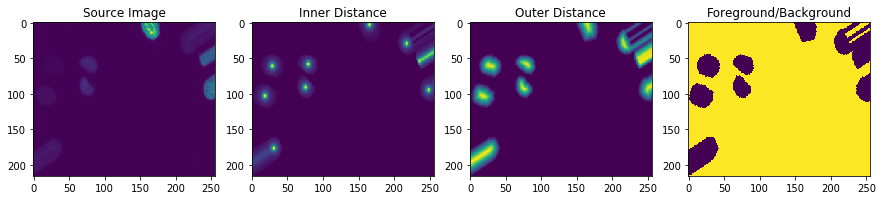

In [8]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()

In [9]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if 'semantic_' in layer.name:
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [10]:
model.compile(loss=loss, optimizer=optimizer)

In [11]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/3
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 643/5809 [==>...........................] - ETA: 4:23 - loss: 0.0037 - semantic_0_loss: 9.1472e-04 - semantic_1_loss: 0.0019 - semantic_2_loss: 7.9888e-04
Epoch 00001: val_loss improved from inf to 0.00365, saving model to /data/models/watershed_centroid_nuclear_general_std.h5
5809/5809 [==============================] - 971s 167ms/step - loss: 0.0155 - semantic_0_loss: 0.0016 - semantic_1_loss: 0.0126 - semantic_2_loss: 0.0013 - val_loss: 0.0037 - val_semantic_0_loss: 9.1472e-04 - val_semantic_1_loss: 0.0019 - val_semantic_2_loss: 7.9888e-04
Epoch 2/3
 643/5809 [==>...........................] - ETA: 3:58 - loss: 0.0031 - semantic_0_loss: 7.6465e-04 - semantic_1_loss: 0.0017 - semantic_2_loss: 6.3895e-04
Epoch 00002: val_loss improved from 0.00365 to 0.00313, saving model to /data/models/watershed_centroid_nuclear_general_std.h5
5809/5809 [======================

In [12]:
# make predictions on testing data
from timeit import default_timer

start = default_timer()
test_images = model.predict(X_test)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape, 'in', watershed_time, 'seconds.')

Watershed segmentation of shape (720, 216, 256, 1) in 9.172761011868715 seconds.


665


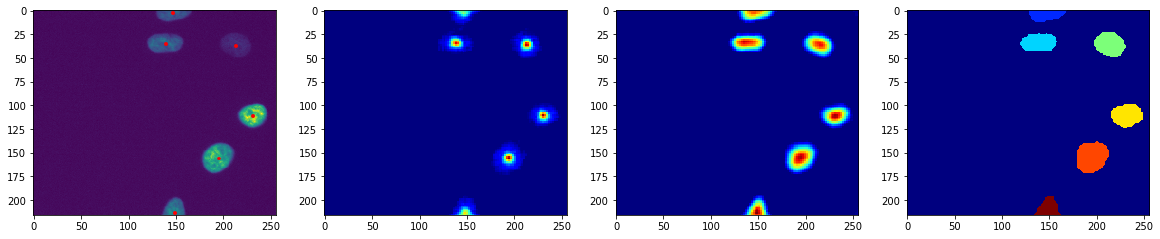

In [13]:
import time

from matplotlib import pyplot as plt
import numpy as np

from deepcell_toolbox.deep_watershed import deep_watershed

from skimage.exposure import equalize_adapthist
from skimage.measure import label
from skimage.morphology import watershed
from deepcell.utils.transform_utils import erode_edges

from scipy import ndimage
from skimage.feature import peak_local_max

index = np.random.choice(X_test.shape[0])
print(index)

fig, axes = plt.subplots(1, 4, figsize=(20, 20))

inner_distance, outer_distance, fgbg = test_images
index = 0

masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=0)

# calculated in the postprocessing above, but useful for visualizing
coords = peak_local_max(
    inner_distance[index],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)

# raw image with centroid
axes[0].imshow(X_test[index, ..., 0])
axes[0].scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)

axes[1].imshow(inner_distance[index, ..., 0], cmap='jet')
axes[2].imshow(outer_distance[index, ..., 0], cmap='jet')
axes[3].imshow(masks[index, ...], cmap='jet')

plt.show()

In [14]:
from deepcell.metrics import Metrics
from skimage.morphology import watershed, remove_small_objects
from skimage.segmentation import clear_border

outputs = model.predict(X_test)

y_pred = []

for i in range(outputs[0].shape[0]):

    mask = deep_watershed(
        [t[[i]] for t in outputs],
        min_distance=10,
        detection_threshold=0.1,
        distance_threshold=0.01,
        exclude_border=False,
        small_objects_threshold=0)

    y_pred.append(mask[0])

y_pred = np.stack(y_pred, axis=0)
y_pred = np.expand_dims(y_pred, axis=-1)
y_true = y_test.copy()

print('DeepWatershed - Remove no pixels')
m = Metrics('DeepWatershed - Remove no pixels', seg=False)
m.calc_object_stats(y_true, y_pred)
print('\n')


for i in range(y_pred.shape[0]):
    y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=100)
    y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=100)


print('DeepWatershed - Remove objects < 100 pixels')
m = Metrics('DeepWatershed - Remove 100 pixels', seg=False)
m.calc_object_stats(y_true, y_pred)
print('\n')

DeepWatershed - Remove no pixels
INFO:tensorflow:0 samples processed
INFO:tensorflow:500 samples processed

____________Object-based statistics____________

Number of true cells:		 5052
Number of predicted cells:	 5173

Correct detections:  4614	Recall: 91.330166270783848858627607114613056182861328125%
Incorrect detections: 559	Precision: 89.1938913589793145320072653703391551971435546875%

Gained detections: 527	Perc Error: 56.2433297758804684463029843755066394805908203125%
Missed detections: 380	Perc Error: 40.55496264674493289703605114482343196868896484375%
Merges: 28		Perc Error: 2.988260405549626685939301751204766333103179931640625%
Splits: 2		Perc Error: 0.2134471718249733307448678942819242365658283233642578125%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 2
Missed detections from merges: 28
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80719788189680252710189733988954685628414

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?


DeepWatershed - Remove objects < 100 pixels
INFO:tensorflow:0 samples processed
INFO:tensorflow:500 samples processed

____________Object-based statistics____________

Number of true cells:		 4809
Number of predicted cells:	 4974

Correct detections:  4515	Recall: 93.8864628820960689381536212749779224395751953125%
Incorrect detections: 459	Precision: 90.7720144752714048763664322905242443084716796875%

Gained detections: 429	Perc Error: 61.726618705035974699057987891137599945068359375%
Missed detections: 237	Perc Error: 34.10071942446042925212168483994901180267333984375%
Merges: 28		Perc Error: 4.028776978417266008136721211485564708709716796875%
Splits: 1		Perc Error: 0.14388489208633092886202575755305588245391845703125%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 28
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80777972272764064776140457979636266827